In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
from sklearn import model_selection
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

In [2]:
image_path = "/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/"
mask_path = "/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/"

In [3]:
image_list = sorted(glob(image_path + "*.jpg"))[0:2000]
mask_list = sorted(glob(mask_path + "*.jpg"))[0:2000]

In [4]:
num_classes=2
IMG_HEIGHT=256
IMG_WIDTH=256
IMG_CHANNELS=3
n_features=16

In [5]:
def binarylab(labels):
    x = np.zeros([labels.shape[0],labels.shape[1],2])  
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
             # Get the color at the pixel
            color = labels[i, j]
             # Check if the color is close to red
            if np.allclose(color, [255,255,255], atol=10):  # Water (White)
                color_idx = 1
            else:
                color_idx = 0  # Black (Background)
            x[i, j, color_idx] = 1
    return x

def make_dataset(image_list, mask_list):
  images = []
  masks = []
    
  for img, mask in zip(image_list, mask_list):
    images.append(cv2.cvtColor(cv2.resize(cv2.imread(img), (IMG_HEIGHT,IMG_WIDTH)), cv2.COLOR_BGR2RGB))      
    masks.append(binarylab(cv2.cvtColor(cv2.resize(cv2.imread(mask), (IMG_HEIGHT,IMG_WIDTH)), cv2.COLOR_BGR2RGB)))
        
  images = np.array(images)
  masks = np.array(masks)
  return images, masks

In [6]:
image,mask = make_dataset(image_list, mask_list)

In [7]:
unique_colors = np.unique(mask.reshape(-1, mask.shape[3]),axis=0)
num_unique_colors = unique_colors.shape[0]
print(f"Number of unique colors in the mask dataset : {num_unique_colors}")
print(f"Unique colors are :{unique_colors}")

Number of unique colors in the mask dataset : 2
Unique colors are :[[0. 1.]
 [1. 0.]]


In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(image, mask, test_size = 0.2, random_state = 3)

print(X_train.shape, X_test.shape)

(1600, 256, 256, 3) (400, 256, 256, 3)


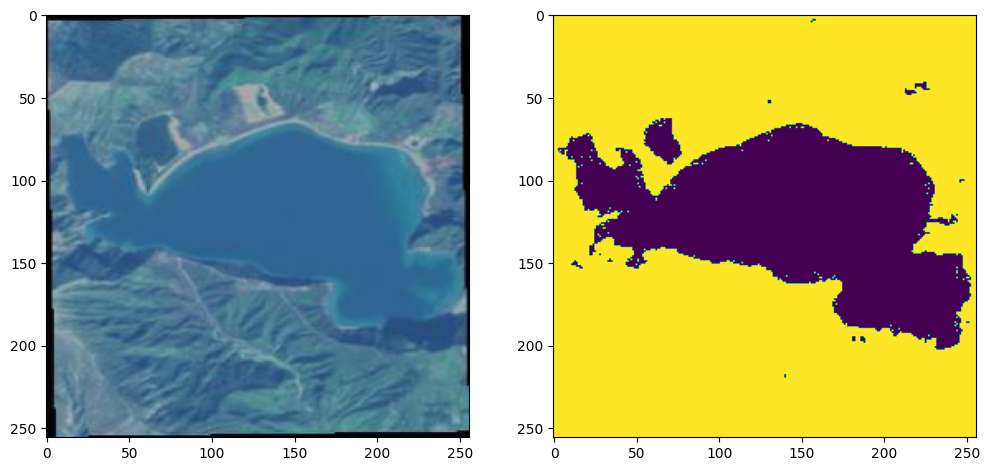

In [9]:
import random
import numpy as np
image_number = random.randint(0, len(image))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image[image_number])
plt.subplot(122)
plt.imshow(mask[image_number][:,:,0])
plt.show()

In [10]:
from keras import backend as K
def jaccard_coef(y_true, y_pred):
    y_true_f = tf.argmax(y_true, axis=-1)
    y_pred_f = tf.argmax(y_pred, axis=-1)
    jaccard = 0
    for i in range(num_classes):
        y_true_i = tf.cast(tf.equal(y_true_f, i), K.floatx())
        y_pred_i = tf.cast(tf.equal(y_pred_f, i), K.floatx())
        intersection = tf.reduce_sum(y_true_i * y_pred_i)
        union = tf.reduce_sum(y_true_i) + tf.reduce_sum(y_pred_i) - intersection
        jaccard += (intersection + 1.0) / (union + 1.0)
    return jaccard / num_classes

def dice_coef(y_true, y_pred):
    y_true_f = tf.argmax(y_true, axis=-1)
    y_pred_f = tf.argmax(y_pred, axis=-1)
    dice = 0
    for i in range(num_classes):
        y_true_i = tf.cast(tf.equal(y_true_f, i), K.floatx())
        y_pred_i = tf.cast(tf.equal(y_pred_f, i), K.floatx())
        intersection = tf.reduce_sum(y_true_i * y_pred_i)
        dice += (2. * intersection + 1.0) / (tf.reduce_sum(y_true_i) + tf.reduce_sum(y_pred_i) + 1.0)
    return dice / num_classes


In [11]:
metrics = ['accuracy', jaccard_coef, dice_coef, 'recall' , 'precision']

In [12]:
# Defining the Convolutional Block
def conv_block(inputs, num_filters):
    x = tf.keras.Sequential([
        tf.keras.layers.Conv2D(num_filters, 3, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(num_filters, 3, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu')
    ])(inputs)
    return x

In [13]:
class SkipWrapper(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SkipWrapper, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs

def encoder_block(inputs, num_filters, name="encoder_block"): 
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same', kernel_initializer="he_uniform")(inputs) 
    x = tf.keras.layers.Activation('relu')(x)  
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same', kernel_initializer="he_uniform")(x) 
    x = tf.keras.layers.Activation('relu')(x) 
    skip = SkipWrapper()(x)  # Wrap skip connection as a Keras layer
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)
    return x, skip  # Return output and skip connection as Keras layers

def decoder_block(inputs, skip_features, num_filters, name="decoder_block"): 
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs) 
    skip_features = tf.keras.layers.Conv2D(num_filters, 1, padding='same')(skip_features)  # Adjust channels
    skip_features = tf.keras.layers.Activation('relu')(skip_features)  # Activation
    skip_features = tf.keras.layers.UpSampling2D(size=(2, 2))(skip_features)  # Upsample to match size
    if skip_features.shape[-1] != num_filters:  # Check channel dimension
         skip_features = tf.keras.layers.Conv2D(num_filters, 1, padding='same')(skip_features)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same', kernel_initializer="he_uniform")(x) 
    x = tf.keras.layers.Activation('relu')(x) 
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same', kernel_initializer="he_uniform")(x)
    x = tf.keras.layers.Activation('relu')(x) 
    return x

def unet_plus_plus_model(input_shape=(256, 256, 3), num_classes=2): 
    inputs = tf.keras.layers.Input(shape=input_shape) 

    s1, skip1 = encoder_block(inputs, 64) 
    s2, skip2 = encoder_block(s1, 128) 
    s3, skip3 = encoder_block(s2, 256) 
    s4, skip4 = encoder_block(s3, 512) 

    b1 = tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), padding="same", kernel_initializer="he_uniform")(s4) 
    b1 = tf.keras.layers.Activation('relu')(b1) 
    b1 = tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), padding="same", kernel_initializer="he_uniform")(b1) 
    b1 = tf.keras.layers.Activation('relu')(b1) 

    s5 = decoder_block(b1, skip4, 512) 
    s6 = decoder_block(s5, skip3, 256) 
    s7 = decoder_block(s6, skip2, 128) 
    s8 = decoder_block(s7, skip1, 64) 

    outputs = tf.keras.layers.Conv2D(filters=num_classes, kernel_size=(1, 1), padding="same", activation="sigmoid")(s8) 

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs], name='U_Net') 
    return model

In [14]:
model = unet_plus_plus_model()
model.summary()

Model: "U_Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 100)    │       460,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 16, 16, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 100)    │        90,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 16, 16, 100)    │             

 Total params: 12,399,194 (47.30 MB)

 Trainable params: 12,399,194 (47.30 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
c1 = tf.keras.callbacks.EarlyStopping(mode='max',monitor='val_jaccard_coef', patience = 10, restore_best_weights = True)
# Using Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)
history = model.fit(np.array(X_train,dtype='float16'),np.array(y_train,dtype='float16'),epochs=500,verbose=1,batch_size=8,validation_split=0.1) 

Epoch 1/500


I0000 00:00:1728029010.043695      68 service.cc:145] XLA service 0x7886e8002570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728029010.043805      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/180 ━━━━━━━━━━━━━━━━━━━━ 54:24 18s/step - accuracy: 0.2644 - dice_coef: 0.2368 - jaccard_coef: 0.1421 - loss: 7.7439 - precision: 0.3188 - recall: 0.3319

I0000 00:00:1728029022.314826      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


180/180 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.6615 - dice_coef: 0.4099 - jaccard_coef: 0.3379 - loss: 1.0263 - precision: 0.6218 - recall: 0.5761 - val_accuracy: 0.6870 - val_dice_coef: 0.4061 - val_jaccard_coef: 0.3435 - val_loss: 0.6180 - val_precision: 0.6870 - val_recall: 0.6870
Epoch 2/500
180/180 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.6848 - dice_coef: 0.4148 - jaccard_coef: 0.3481 - loss: 0.6237 - precision: 0.6844 - recall: 0.6814 - val_accuracy: 0.6870 - val_dice_coef: 0.4061 - val_jaccard_coef: 0.3435 - val_loss: 0.6228 - val_precision: 0.6870 - val_recall: 0.6870
Epoch 3/500
180/180 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.6999 - dice_coef: 0.4425 - jaccard_coef: 0.3701 - loss: 0.6054 - precision: 0.6913 - recall: 0.7060 - val_accuracy: 0.6944 - val_dice_coef: 0.4254 - val_jaccard_coef: 0.3560 - val_loss: 0.6133 - val_precision: 0.6943 - val_recall: 0.6944
Epoch 4/500
180/180 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.7073 - dice_coef: 

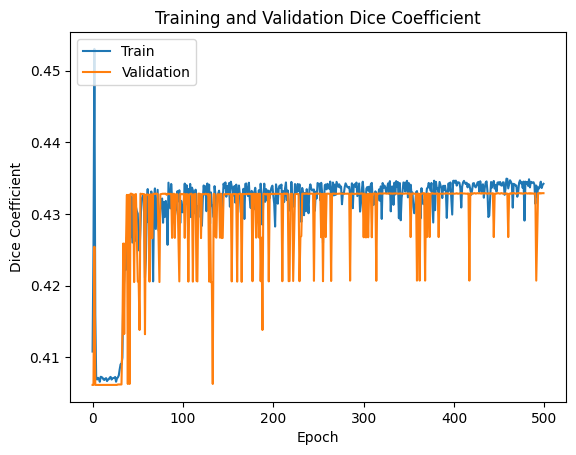

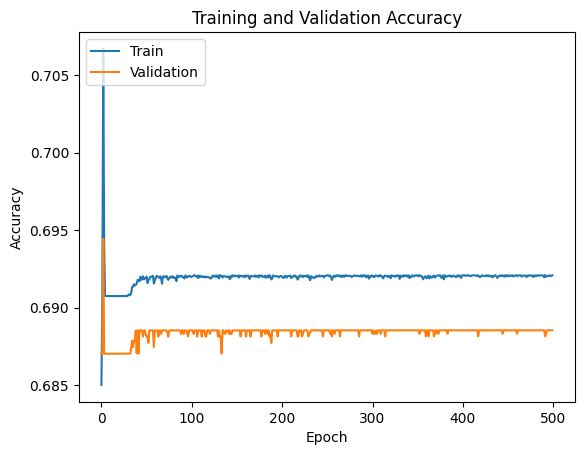

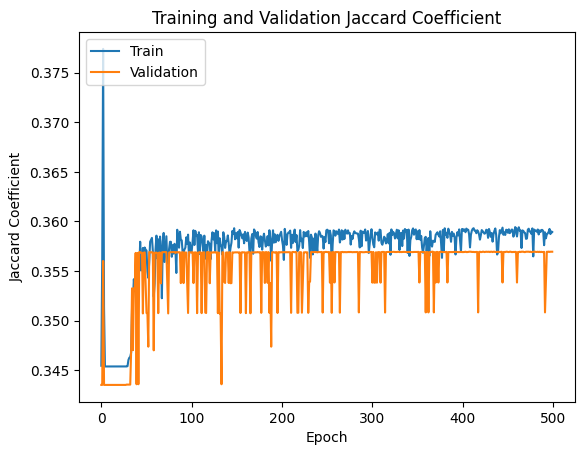

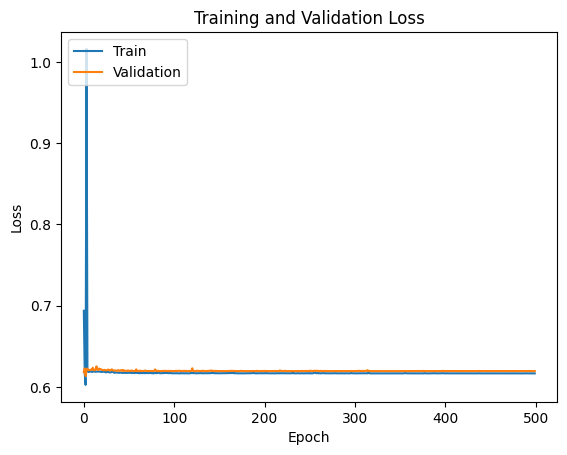

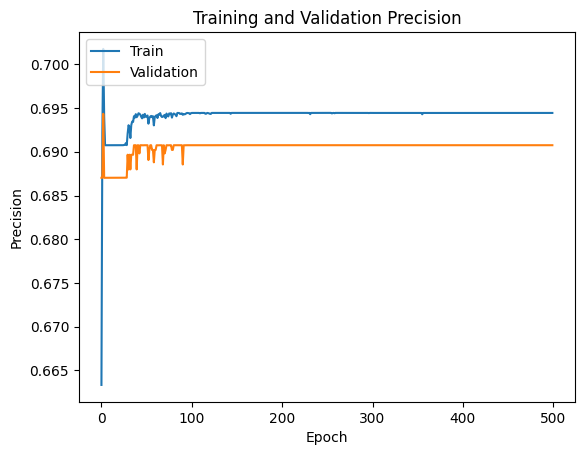

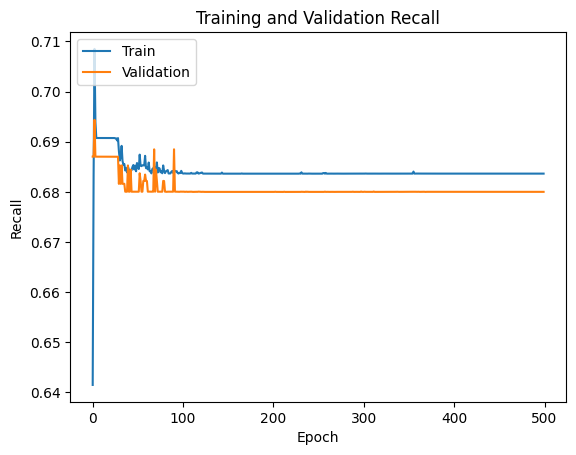

In [16]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Training and Validation Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['jaccard_coef'])
plt.plot(history.history['val_jaccard_coef'])
plt.title('Training and Validation Jaccard Coefficient')
plt.ylabel('Jaccard Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Training and Validation Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Training and Validation Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
model.evaluate(X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 732ms/step - accuracy: 0.7029 - dice_coef: 0.4359 - jaccard_coef: 0.3627 - loss: 0.6072 - precision: 0.7065 - recall: 0.6955


[0.6145102381706238,
 0.6940279603004456,
 0.3575374484062195,
 0.43181830644607544,
 0.6866140961647034,
 0.6974586248397827]

In [18]:
from sklearn.metrics import jaccard_score, f1_score 
from keras import backend as K

# Get predictions for the test data
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=-1)
y_test_argmax = np.argmax(y_test, axis=-1)

# Jaccard Index (IoU) for each class
from keras.metrics import MeanIoU
iou_keras = MeanIoU(num_classes=num_classes)
iou_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", iou_keras.result().numpy())

# Jaccard Index using sklearn
iou_per_class = jaccard_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average=None)
print("IoU per class:", iou_per_class)

# Dice Coefficient (F1 Score) for each class
dice_per_class = f1_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average=None)
print("Dice Coefficient per class:", dice_per_class)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step
Mean IoU = 0.35014915
IoU per class: [0.69173372 0.02374559]
Dice Coefficient per class: [0.81778085 0.04638963]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


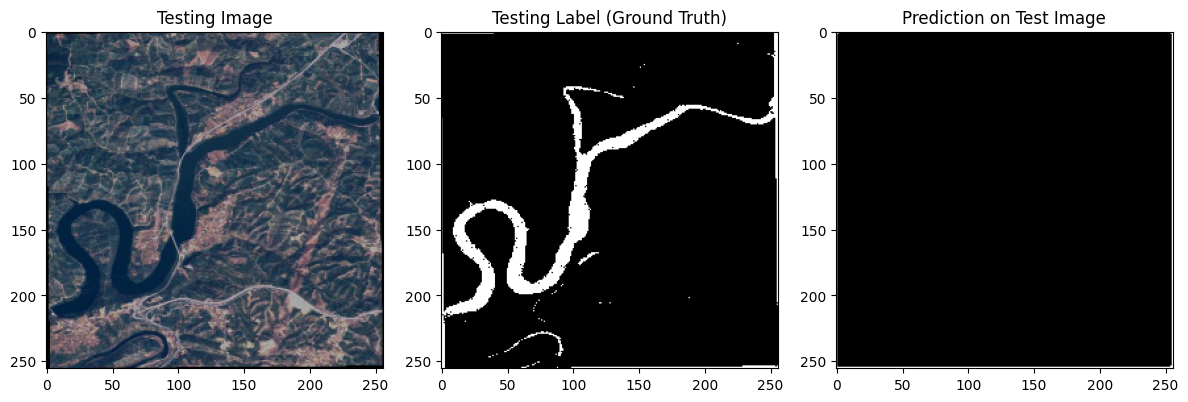

In [19]:
import random
test_img_number = random.randint(0, len(X_test) - 1)  # Ensure correct range
test_img = X_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]

# Expand dimensions to fit model input
test_img_input = np.expand_dims(test_img, 0)
prediction = model.predict(test_img_input)
predicted_img = np.argmax(prediction, axis=3)[0, :, :]

# Plotting the results
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)

plt.subplot(232)
plt.title('Testing Label (Ground Truth)')
plt.imshow(ground_truth, cmap='gray')  # Use gray to differentiate background and foreground

plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(predicted_img, cmap='gray')  # Use gray to differentiate background and foreground

plt.tight_layout()
plt.show()


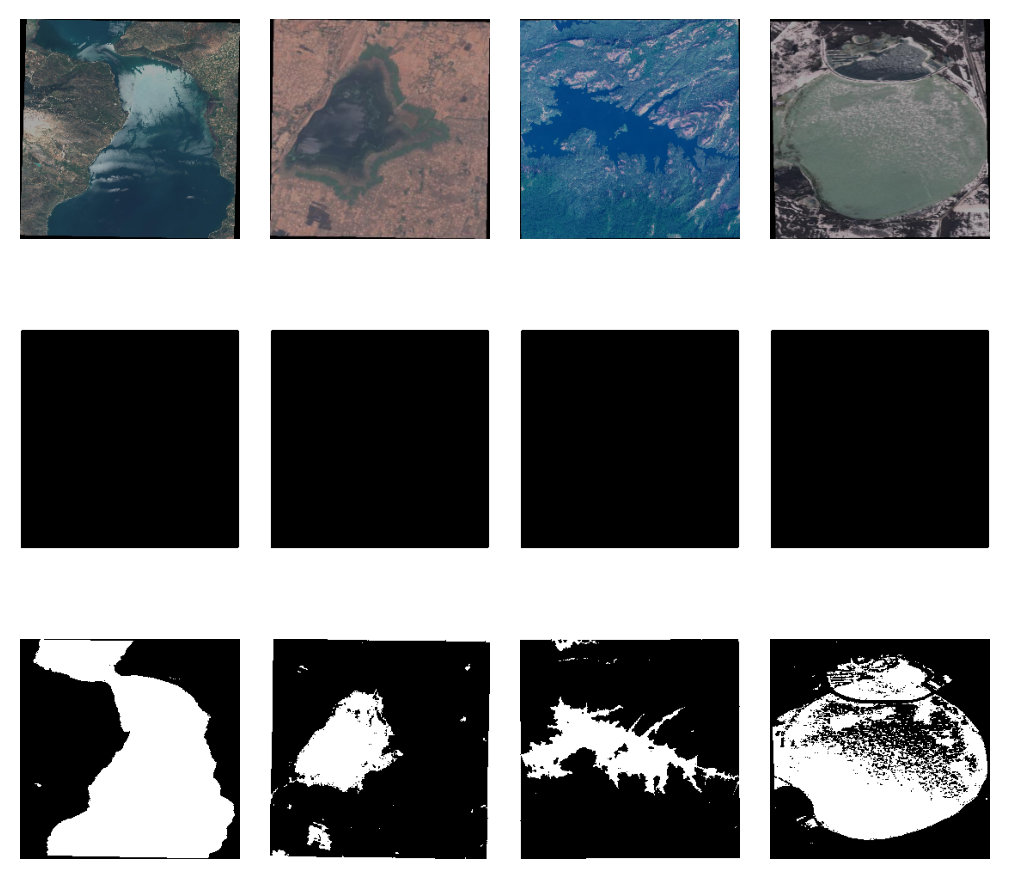

In [20]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Define colors for background (black) and foreground (white) in BGR format
label_colours = np.array([[0, 0, 0],     # Black (Background)
                          [255, 255, 255]])  # White (Foreground)

def visualize(temp, plot=True, swap_colors=False):
    b = np.zeros(temp.shape)
    g = np.zeros(temp.shape)
    r = np.zeros(temp.shape)

    for l in [0, 1]:  # Indices: 0 (background), 1 (foreground)
        if swap_colors and l == 0:  # Swap black and white
            g[temp == l] = label_colours[1, 1]  # Use white for green
            b[temp == l] = label_colours[1, 0]  # Use white for blue
            r[temp == l] = label_colours[1, 2]  # Use white for red
        else:
            b[temp == l] = label_colours[l, 0]
            g[temp == l] = label_colours[l, 1]
            r[temp == l] = label_colours[l, 2]

    # Create the RGB output
    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0  # Red channel
    rgb[:, :, 1] = g / 255.0  # Green channel
    rgb[:, :, 2] = b / 255.0  # Blue channel
    
    if plot:
        plt.imshow(rgb)
        plt.axis('off')  # Hide axes
        plt.show()
    else:
        return rgb

# Example plotting code (assuming y_pred and y_test are available and contain the correct data)
randsample = random.sample(range(0, len(y_pred)), 4)
gs = GridSpec(3, 5)
plt.figure(dpi=200)

for i in range(4):
    output = visualize(np.argmax(y_pred[randsample[i]], axis=2), plot=False, swap_colors=False)  # Swap colors for predicted
    out_test = visualize(np.argmax(y_test[randsample[i]], axis=2), plot=False)
        
    plt.subplot(gs[i]), plt.imshow(X_test[randsample[i]]), plt.axis('off')
    plt.subplot(gs[5 + i]), plt.imshow(output), plt.axis('off')
    plt.subplot(gs[10 + i]), plt.imshow(out_test), plt.axis('off')

plt.tight_layout()
plt.show()


In [21]:
model.save('models/unet_plus_plus_500_epochs.h5')

In [22]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/working/__notebook__.ipynb
/kaggle/working/models/unet_plus_plus_500_epochs.h5
